# **Siamese Network**

**Load data:**

In [ ]:
from tensorflow.keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)
(60000,)


**Build model CNN**

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

inp = Input(shape=(28,28,1))
x = Conv2D(filters = 8, kernel_size = 3, activation = 'relu')(inp)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Flatten()(x)
x = Dense(units = 32, activation = 'relu')(x)
x = Dense(units = 2)(x)

cnn = Model(inputs = inp, outputs = x)
img1 = Input(shape = (28,28,1))
img2 = Input(shape = (28,28,1))

f1 = cnn(img1)
f2 = cnn(img2)

d = K.sqrt(K.sum(K.square(f1 - f2),axis = 1, keepdims = True))

model = Model(inputs = [img1,img2], outputs = d)
model.summary()
cnn.summary()

def loss(y_true, y_pred):
  proba = K.exp(-K.square(y_pred))
  return -K.mean(y_true * K.log(proba) + (1-y_true) * K.log(1-proba))

def loss1(y_true, y_pred):
  return K.mean(y_true * K.square(y_pred) + (1-y_true) * K.square(K.maximum(1.0 - y_pred, 0)))

model.compile(optimizer = 'adam', loss = loss1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 2)            43442       ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 2)            0           ['model[0][0]',            

**Make all pairs or other strategies; some innovation here**

Batch size:  160
(28, 28, 1)
Pair label: 1.0


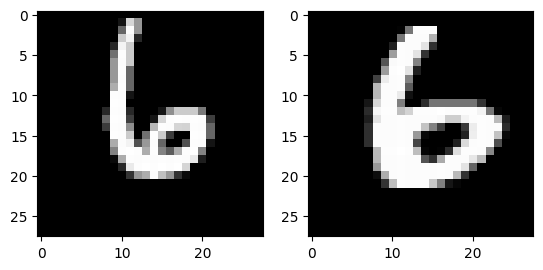

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def generator(X,y,k = 8):
  unique_labels = np.unique(y)

  while True:
    X1 = []
    X2 = []
    y_batch = []
    for label in unique_labels:
      label_idx = np.where(y == label)[0]
      other_labels = set(unique_labels) - {label}

      for i in range(k):
        i1 = np.random.choice(label_idx)
        i2 = np.random.choice(label_idx)
        # i1 must be different from i2
        while i1 == i2:
          i2 = np.random.choice(label_idx)
        # create positive example
        X1.append(X[i1][:,:,None])
        X2.append(X[i2][:,:,None])
        y_batch.append(1.0)

        # create negative example
        i1 = np.random.choice(label_idx)
        my_label = np.random.choice(list(other_labels))
        i2 = np.random.choice(list(np.where(y == my_label)[0]))
        X1.append(X[i1][:,:,None])
        X2.append(X[i2][:,:,None])
        y_batch.append(0.0)
    yield [np.array(X1) / 255., np.array(X2) / 255.], np.array(y_batch)

# For testing
for pair, y in generator(X_test, y_test):
  print('Batch size: ', len(y))
  idx = np.random.choice(range(len(y)))
  print(pair[0][idx].shape)
  print('Pair label:', y[idx])
  plt.subplot(121)
  plt.imshow(pair[0][idx].reshape(28,28), cmap = 'gray')
  plt.subplot(122)
  plt.imshow(pair[1][idx].reshape(28,28), cmap = 'gray')

  break

**Fit model**

In [ ]:
history = model.fit(generator(X_train, y_train, k = 32),
                    steps_per_epoch = 10,
                    epochs = 50,
                    validation_data = generator(X_test, y_test, k = 8),
                    validation_steps = 5)

Epoch 1/50
10/10 [==============================] - 3s 279ms/step - loss: 0.0587 - val_loss: 0.0643
Epoch 2/50
10/10 [==============================] - 2s 274ms/step - loss: 0.0590 - val_loss: 0.0679
Epoch 3/50
10/10 [==============================] - 3s 293ms/step - loss: 0.0557 - val_loss: 0.0654
Epoch 4/50
10/10 [==============================] - 3s 361ms/step - loss: 0.0554 - val_loss: 0.0645
Epoch 5/50
10/10 [==============================] - 2s 268ms/step - loss: 0.0572 - val_loss: 0.0649
Epoch 6/50
10/10 [==============================] - 2s 272ms/step - loss: 0.0590 - val_loss: 0.0615
Epoch 7/50
10/10 [==============================] - 2s 272ms/step - loss: 0.0543 - val_loss: 0.0593
Epoch 8/50
10/10 [==============================] - 3s 378ms/step - loss: 0.0576 - val_loss: 0.0607
Epoch 9/50
10/10 [==============================] - 2s 269ms/step - loss: 0.0540 - val_loss: 0.0533
Epoch 10/50
10/10 [==============================] - 2s 272ms/step - loss: 0.0562 - val_loss: 0.0663

**Visualize learning process**

Text(0, 0.5, 'Loss')

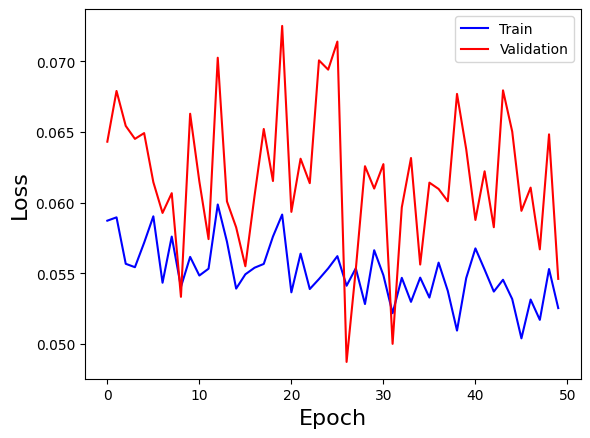

In [ ]:
plt.plot(history.history['loss'], label = 'Train', c = 'b')
plt.plot(history.history['val_loss'], label = 'Validation', c = 'r')
plt.legend()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

5/5 [==============================] - 0s 3ms/step
Batch_size:  160
Pair label: 1.0
Distance: [0.31551546]
Distance by features: [0.31551543]


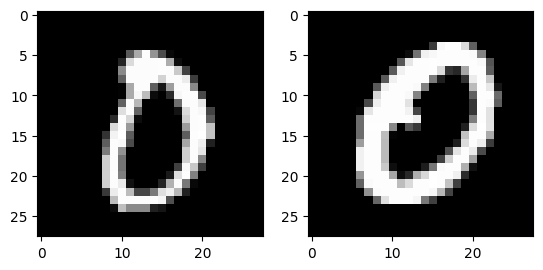

In [ ]:
for pair, y in generator(X_test, y_test):
  y_pred = model.predict(pair)
  print('Batch_size: ', len(y))
  idx = np.random.choice(range(len(y)))
  print('Pair label:', y[idx])
  print('Distance:', y_pred[idx])

  f1 = cnn(pair[0])
  f2 = cnn(pair[1])
  d = np.sqrt(np.sum((f1-f2)**2,axis = 1, keepdims = True))
  print('Distance by features:', d[idx])

  plt.subplot(121)
  plt.imshow(pair[0][idx].reshape(28,28),cmap = 'gray')
  plt.subplot(122)
  plt.imshow(pair[1][idx].reshape(28,28),cmap = 'gray')
  break

**Visualize new feature space**

313/313 [==============================] - 1s 2ms/step


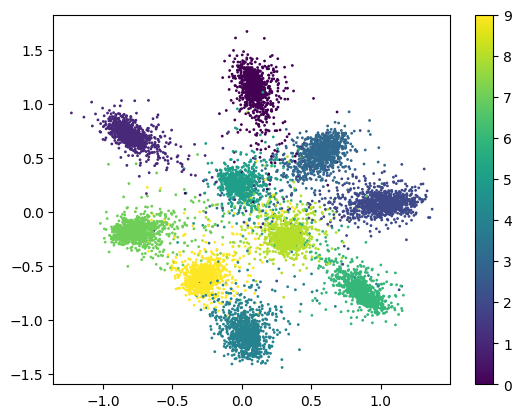

In [ ]:
f = cnn.predict(X_test/255.)
p = plt.scatter(f[:,0],f[:,1], c = y_test, s=1)
plt.colorbar(p)

**Save model**

In [ ]:
cnn.save('cnn_loss1.h5')

**Load model and test**

313/313 [==============================] - 1s 1ms/step


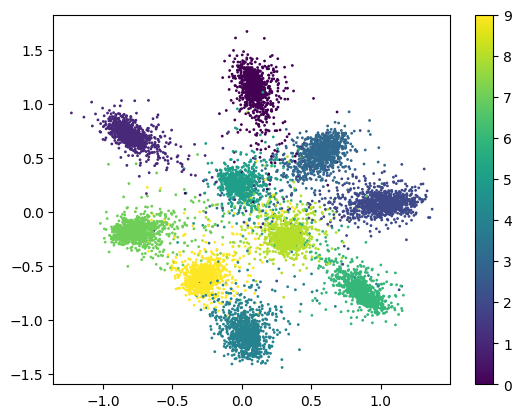

In [ ]:
from tensorflow.keras.models import load_model
m = load_model('cnn_loss1.h5')

f1 = m.predict(X_test / 255.)
p = plt.scatter(f1[:,0],f1[:,1],c=y_test,s=1)
plt.colorbar(p)

**Visualize negative distance and positive distance**

In [ ]:
i = 0
y_true = []
y_pred = []
for pair,y in generator(X_test,y_test):
  f1 = cnn(pair[0])
  f2 = cnn(pair[1])
  d = np.sqrt(np.sum((f1 - f2)**2, axis = 1, keepdims = True))
  y_pred +=list(d.ravel())
  y_true +=list(y)
  i+=1
  if i>500:
    break

**Plot histogram**

(array([1.52630560e-02, 5.08190388e-02, 1.32511077e-01, 3.50703401e-01,
        6.85276668e-01, 8.65484474e-01, 8.56118864e-01, 6.00636067e-01,
        5.61263847e-01, 7.08171257e-01, 6.38967159e-01, 4.40894277e-01,
        3.31798093e-01, 2.73347514e-01, 2.08652784e-01, 1.34765763e-01,
        6.98979312e-02, 2.23742387e-02, 4.16265595e-03, 5.20331132e-04]),
 array([0.02938122, 0.17323241, 0.3170836 , 0.46093479, 0.60478598,
        0.74863714, 0.89248836, 1.03633952, 1.18019068, 1.32404196,
        1.46789312, 1.61174428, 1.75559545, 1.89944661, 2.04329777,
        2.18714905, 2.33100033, 2.47485137, 2.61870265, 2.76255369,
        2.90640497]),
 <BarContainer object of 20 artists>)

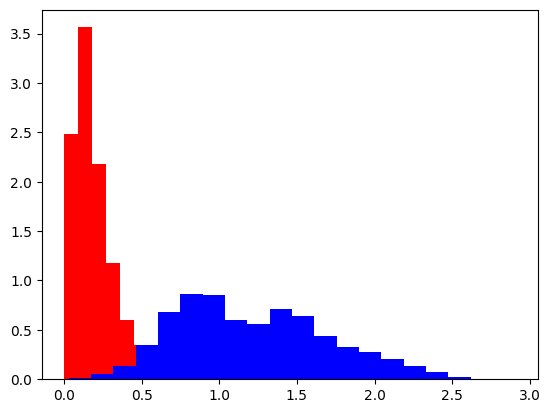

In [ ]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

positive_distances = y_pred[y_true == 1]
negative_distances = y_pred[y_true == 0]

plt.hist(positive_distances, color = 'r', density = True, bins = 20)
plt.hist(negative_distances, color = 'b', density = True, bins = 20)

**Check report using sklearn**

In [ ]:
thresh = 0.5
y_pred_ = y_pred < thresh
y_pred_.astype('uint8')
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94     40080
         1.0       0.96      0.92      0.94     40080

    accuracy                           0.94     80160
   macro avg       0.94      0.94      0.94     80160
weighted avg       0.94      0.94      0.94     80160

